In [73]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models
from torcheval.metrics.functional import binary_auroc
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import zipfile
import shutil 
from tqdm import tqdm
import sys
import cv2
from functools import reduce

In [74]:
train_dir = 'lab5_data/train'
val_dir = 'lab5_data/validation'

class_names = ['horses', 'humans']

# for dir_name in [train_dir, val_dir]:
#     for class_name in class_names:
#         os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# for class_name in class_names:
#     source_dir = os.path.join('.', 'train', class_name)
#     for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
#         dest_dir = os.path.join(train_dir, class_name)
#         # if i % 6 != 0:
#         #     dest_dir = os.path.join(train_dir, class_name)
#         # else:
#         #     dest_dir = os.path.join(val_dir, class_name)
#         shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

In [75]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(0.75),
    transforms.RandomVerticalFlip(0.75),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
cpuset_workers = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=cpuset_workers)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=cpuset_workers)

In [76]:
class CNN(torch.nn.Module):

    def __init__(
        self
    ):
        
        super().__init__() 
        self.convC_16 = torch.nn.Conv2d(3, 16, (3, 3))
        self.convC_32 = torch.nn.Conv2d(16, 32, (3, 3))
        self.convC_64 = torch.nn.Conv2d(32, 64, (3, 3))
        self.convC_128 = torch.nn.Conv2d(64, 128, (3, 3))
        
        self.bn16 = torch.nn.BatchNorm2d(16)
        self.bn32 = torch.nn.BatchNorm2d(32)
        self.bn64 = torch.nn.BatchNorm2d(64)
        self.bn128 = torch.nn.BatchNorm2d(128)
        
        self.convC = torch.nn.Conv2d(512, 512, (3, 3))
        self.maxpool = torch.nn.MaxPool2d((2, 2))
        self.fc = torch.nn.LazyLinear(1)
        self.relu = torch.nn.ReLU()
        
        self.flat = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(0.3)
        

    def forward(self, X):
        x = self.convC_16(X) # [B, C, L, 1] -> [B, C, L]
        x = self.bn16(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.convC_32(x)
        x = self.bn32(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.convC_64(x)
        x = self.bn64(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.flat(x)
        x = self.dropout(x)
        prediction = self.fc(x).squeeze(1)

        return prediction

In [77]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    losses = {'train':[], 'val':[]}
    metrics = {'train':[], 'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch+1, num_epochs), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_auroc = 0.
            # Iterate over data.
            for inputs, labels in tqdm(dataloader, file=sys.stdout):
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    # preds_class = preds.argmax(dim=1)
                    # preds_class = torch.nn.functional.softmax(preds)
                    preds_class = preds.round()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                # if phase == 'val':
                #     print(f'\npred: {preds_class}')
                #     print(f'gtr:  {labels}')
                #     print(f'metric: {binary_auroc(preds_class.cpu().detach(), labels.cpu().detach())}')
                running_auroc += binary_auroc(preds_class.cpu().detach(), labels.cpu().detach())

            epoch_loss = running_loss / len(dataloader)
            epoch_auroc = running_auroc / len(dataloader)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            losses[phase].append(epoch_loss)
            metrics[phase].append(float(epoch_auroc))
            print('\r', flush=True)
    
    fig = plt.figure(figsize=(12, 5))   
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_title("Loss")
    ax1.plot(losses['train'], label='train')
    ax1.plot(losses['val'], label='val')
    ax1.legend()
    ax2.set_title("ROC AUC")
    ax2.plot(metrics['train'], label='train')
    ax2.plot(metrics['val'], label='val')
    ax2.legend()
    plt.show()
    # return model

In [78]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Epoch 1/20:
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:14<00:00,  4.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]

Epoch 2/20:
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:14<00:00,  4.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]

Epoch 3/20:
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:16<00:00,  3.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]

Epoch 4/20:
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:16<00:00,  3.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:

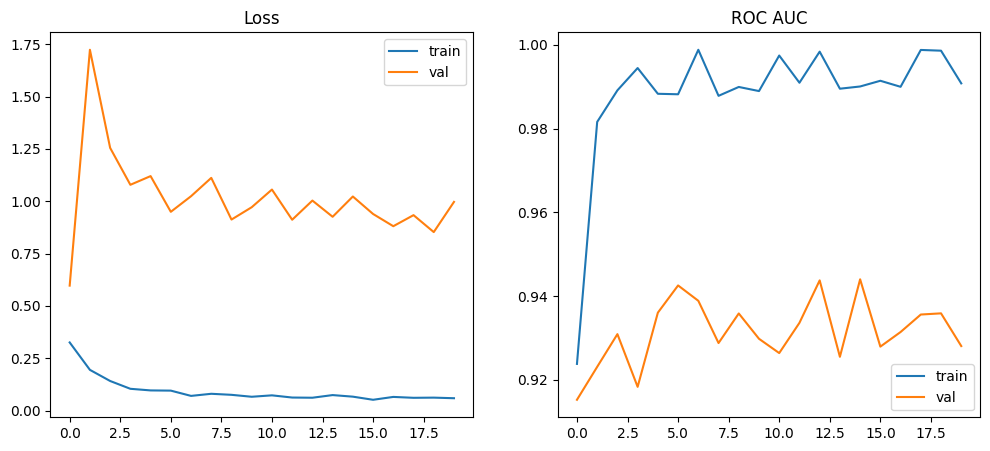

In [79]:
train_model(model, loss, optimizer, scheduler, num_epochs=20)